# MC906A - Trabalho final - Detecção de Pneumonia por Imagens de Raio-X
Felipe Duarte Domingues  RA: 171036  
Lukas Antunes Lopes  RA: 117856  
Renato Aparecido de Oliveira  RA: 092844

                 Ciência da Computação - Graduação


# Basic imports (setting tensorflow and keras parameters to GPU)

In [0]:
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import time
import random
from functools import reduce
from threading import Thread
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from glob import glob
from skimage import color
from skimage import io
from skimage.transform import resize
from PIL import Image, ImageOps, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


from tensorflow.keras.backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

# Connecting to GoogleDrive


In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Dataset Parameters
The dataset available on the google drive is already preprocessed.  
The tensorflow dataset API was used to allow the use of all images on the training, without the need to fit everything in the RAM.

In [0]:
# Dataset Parameters
DATABASE_PATH = '/content/drive/My Drive/ChestXRayLarger'

EPOCHS = 100  # Actually a training parameter, but we need to calculate the repeats
IMAGE_SIZE = (300,300) # The images are stored at 300x300 pixels, you can resize them using this parameter

BATCH_SIZE = 8 # Smaller images allow the usage of greater batch sizes

NORMAL = 0
PNEUMONIA = 1
NUM_CLASSES = 2

os.listdir(DATABASE_PATH)

In [0]:
# https://www.tensorflow.org/beta/tutorials/load_data/images

def _red_list(l):
    return reduce(lambda a,b: a+b, l)

def _parse_function(filename, label):
    image_string = tf.read_file(filename, "file_reader")
    image_decoded = tf.image.decode_png(image_string, channels=3)
    image_decoded = tf.image.rgb_to_grayscale(image_decoded)
    image_decoded = tf.image.resize(image_decoded, IMAGE_SIZE)
    image = tf.cast(image_decoded, tf.int8)
    return image, label

def _dataset(images, d_set='train'):
    # images[0] = class[0], images[1] = class[1] ...
    images_ds = tf.data.Dataset.from_tensor_slices(_red_list(images))
    labels = []
    for i, imgs in enumerate(images):
      labels += [i]*len(imgs)
      
    def type_to_output(num_classes, x):
      n = np.zeros(num_classes)
      n[x] = 1
      return n
    labels = np.array([type_to_output(NUM_CLASSES, x) for x in labels])
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.int8))
    
    images_label_ds = tf.data.Dataset.zip((images_ds, label_ds))
    
    images_label_ds = images_label_ds.shuffle(len(_red_list(images))).repeat(len(_red_list(images))*EPOCHS*BATCH_SIZE).map(_parse_function).batch(BATCH_SIZE)
    return images_label_ds.prefetch(tf.contrib.data.AUTOTUNE), tuple(len(x) for x in images)
  
  
images_normal = list(glob(os.path.join(DATABASE_PATH, 'NORMAL_SAMPLE', "**/*.png"), recursive=True))
random.shuffle(images_normal)
images_pneumo = list(glob(os.path.join(DATABASE_PATH, 'PNEUMONIA_SAMPLE', "**/*.png"), recursive=True))
random.shuffle(images_pneumo)


#-------------------# USING ONLY A FRACTION OF THE DATASET #-------------------# 
# Uncomment this to reduce the dataset size (for dev and testing only)
# images_normal = images_normal[:int(len(images_normal)*0.1)]
# images_pneumo = images_pneumo[:int(len(images_pneumo)*0.1)]
#-------------------#-------------------#-------------------#-------------------#

test_images = (images_normal[:int(len(images_normal)*0.2)], 
               images_pneumo[:int(len(images_pneumo)*0.2)])

val_images = (images_normal[int(len(images_normal)*0.2):int(len(images_normal)*0.4)], 
              images_pneumo[int(len(images_pneumo)*0.2):int(len(images_pneumo)*0.4)])

train_images = (images_normal[int(len(images_normal)*0.4):],
                images_pneumo[int(len(images_pneumo)*0.4):])

test_ds, test_ds_length = _dataset(test_images, d_set='test')
val_ds, val_ds_length = _dataset(val_images, d_set='val')
train_ds, train_ds_length = _dataset(train_images, d_set='train')


(len(images_normal), len(images_pneumo)), train_ds_length, test_ds_length, val_ds_length

# Metrics

In [0]:
import matplotlib.pyplot as plt
import matplotlib.figure as fig
%matplotlib inline

def calc_confusion_matrix(sess, iterator, n_items, model):
    confusion_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES))
    for _ in range(n_items):
        x_val, y_true = sess.run(iterator.get_next())
        y_pred = model.predict(x_val)
        for t_val, p_val in zip(y_true.argmax(axis=1), y_pred.argmax(axis=1)):
            confusion_matrix[t_val, p_val] += 1
    return confusion_matrix

def plot_confusion_matrix(cm):
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = list(range(NUM_CLASSES))
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  for i in range(2):
      for j in range(2):
          plt.text(j-0.2,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()
  
  
from tensorflow.keras.callbacks import Callback

CONFUSION_MATRIX_VAL_DATASET_STEPS = int(sum(val_ds_length)/BATCH_SIZE)
class ConfusionMatrix(Callback):
    def __init__(self, model, val_ds, steps=CONFUSION_MATRIX_VAL_DATASET_STEPS):
        super(Callback, self).__init__()
        self.val_ds = val_ds
        self.steps = steps

    def on_epoch_end(self, epoch, logs={}):
        plot_confusion_matrix(calc_confusion_matrix(tf.keras.backend.get_session(), 
                                                    self.val_ds.make_one_shot_iterator(), 
                                                    self.steps,
                                                    model))
CONFUSION_MATRIX_VAL_DATASET_STEPS

# Training Parameters

In [0]:
VALIDATION_STEPS = int(sum(val_ds_length)/BATCH_SIZE)
STEPS_PER_EPOCH = int(sum(train_ds_length)/BATCH_SIZE)
VALIDATION_STEPS, STEPS_PER_EPOCH

In [0]:
# That's JUST AN EXAMPLE to understand how the tensorflow will handle the dataset object
iterator = train_ds.make_one_shot_iterator()
images, labels = iterator.get_next()

with tf.Session() as sess:
    val = sess.run(iterator.get_next())
    # Each iteration will have the batch images and the batch labels
    for img, label in zip(val[0], val[1]):
        print(img.shape)
        
        display(Image.fromarray(img.reshape(*IMAGE_SIZE), mode ='L')) # displaying the images in grayscale
        print(label)

# Models

## Model 1
This model was initially based on Keras MNIST Example (https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py) but it didn't converged, so we randomly added a few layers and changed the dropout parameters and convolution filters to get a better result

In [0]:
out_folder = '/content/drive/My Drive/ChestXRay/Model1Checkpoints/'
filepath = os.path.join(out_folder, "saved-model-{epoch:02d}-{val_acc:.2f}.hdf5")
if not os.path.exists(out_folder):
  os.mkdir(out_folder)

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

model = Sequential()
model.add(Conv2D(256, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(*IMAGE_SIZE, 1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [0]:
model.fit(train_ds.make_one_shot_iterator(),
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          epochs=EPOCHS,
          verbose=1,
          validation_data=val_ds.make_one_shot_iterator(),
          callbacks = [checkpoint])

Epoch 1/10
87/88 [============================>.] - ETA: 1s - loss: 0.7021 - acc: 0.5805
Epoch 00001: saving model to /content/drive/My Drive/ChestXRay/Model1Checkpoints/saved-model-01-0.62.hdf5
88/88 [==============================] - 169s 2s/step - loss: 0.6997 - acc: 0.5824 - val_loss: 0.7963 - val_acc: 0.6250
Epoch 2/10
87/88 [============================>.] - ETA: 0s - loss: 0.6085 - acc: 0.6825
Epoch 00002: saving model to /content/drive/My Drive/ChestXRay/Model1Checkpoints/saved-model-02-0.66.hdf5
88/88 [==============================] - 14s 156ms/step - loss: 0.6082 - acc: 0.6832 - val_loss: 0.7700 - val_acc: 0.6562
Epoch 3/10
87/88 [============================>.] - ETA: 0s - loss: 0.5746 - acc: 0.7112
Epoch 00003: saving model to /content/drive/My Drive/ChestXRay/Model1Checkpoints/saved-model-03-0.78.hdf5
88/88 [==============================] - 12s 138ms/step - loss: 0.5758 - acc: 0.7102 - val_loss: 0.7158 - val_acc: 0.7812
Epoch 4/10
87/88 [============================>.] -

In [0]:
# NOTE -> traning and validation with 10% of the max
# This loads all the saved models in the dataset and get the loss and accuracy of both the test and the validation dataset
for m in os.listdir(out_folder):
  print(m)
  model.load_weights(os.path.join(out_folder, m))
  score = model.evaluate(val_ds.make_one_shot_iterator(), verbose=0, steps=sum(val_ds_length))

  print('Val Test loss:', score[0])
  print('Val Test accuracy:', score[1])


  score = model.evaluate(test_ds.make_one_shot_iterator(), verbose=0, steps=sum(test_ds_length))

  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  print()

saved-model-01-0.62.hdf5
Val Test loss: 0.6062114070070551
Val Test accuracy: 0.69787234
Test loss: 0.5723508135955221
Test accuracy: 0.72103006

saved-model-02-0.66.hdf5
Val Test loss: 0.5506317278172107
Val Test accuracy: 0.71914893
Test loss: 0.5197196426309741
Test accuracy: 0.76824033

saved-model-03-0.78.hdf5
Val Test loss: 0.5016791128097696
Val Test accuracy: 0.8212766
Test loss: 0.4800960074934325
Test accuracy: 0.8197425

saved-model-04-0.75.hdf5
Val Test loss: 0.4797829034480643
Val Test accuracy: 0.81276596
Test loss: 0.4484820963231279
Test accuracy: 0.7982833

saved-model-05-0.94.hdf5
Val Test loss: 0.4539044436622173
Val Test accuracy: 0.83829784
Test loss: 0.4328863670641772
Test accuracy: 0.82403433

saved-model-06-0.88.hdf5
Val Test loss: 0.44571524921883926
Val Test accuracy: 0.83404255
Test loss: 0.42060076096794635
Test accuracy: 0.82403433

saved-model-07-0.75.hdf5
Val Test loss: 0.43533291233346816
Val Test accuracy: 0.83829784
Test loss: 0.40647372584230396
Test

## Model 2
Based on https://www.hindawi.com/journals/jhe/2019/4180949/fig3/  
As the original model didn't perform well in our dataset, we added another Dense layer and changed a few traning parameters to get a better result

In [0]:
out_folder = '/content/drive/My Drive/ChestXRay/Model2Checkpoints/'
filepath = os.path.join(out_folder, "saved-model-{epoch:02d}-{val_acc:.2f}.hdf5")
if not os.path.exists(out_folder):
  os.mkdir(out_folder)

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(*IMAGE_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))

model.add(Dense(512, activation='sigmoid')) # Added another Layer, 512 using sigmoid, the result was really improved in our dataset

model.add(Dense(NUM_CLASSES, activation='softmax')) # This was adapted, the original used only one output neuron

model.compile(loss=keras.losses.categorical_crossentropy, # Used the same loss and optimizer as before
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [0]:
# train and val with reduced dataset
model.fit(train_ds.make_one_shot_iterator(),
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          epochs=EPOCHS,
          verbose=1,
          validation_data=val_ds.make_one_shot_iterator(),
          callbacks = [checkpoint])

Epoch 1/50
879/880 [============================>.] - ETA: 1s - loss: 0.6698 - acc: 0.5973
Epoch 00001: saving model to /content/drive/My Drive/ChestXRay/Model2Checkpoints/saved-model-01-0.62.hdf5
880/880 [==============================] - 1043s 1s/step - loss: 0.6700 - acc: 0.5970 - val_loss: 0.7952 - val_acc: 0.6250
Epoch 2/50
879/880 [============================>.] - ETA: 0s - loss: 0.5844 - acc: 0.6992
Epoch 00002: saving model to /content/drive/My Drive/ChestXRay/Model2Checkpoints/saved-model-02-0.81.hdf5
880/880 [==============================] - 40s 46ms/step - loss: 0.5848 - acc: 0.6991 - val_loss: 0.6483 - val_acc: 0.8125
Epoch 3/50
878/880 [============================>.] - ETA: 0s - loss: 0.5351 - acc: 0.7385
Epoch 00003: saving model to /content/drive/My Drive/ChestXRay/Model2Checkpoints/saved-model-03-0.84.hdf5
880/880 [==============================] - 39s 45ms/step - loss: 0.5350 - acc: 0.7386 - val_loss: 0.6220 - val_acc: 0.8438
Epoch 4/50
878/880 [====================

In [0]:
# This loads all the saved models in the dataset and get the loss and accuracy of both the test and the validation dataset
for m in os.listdir(out_folder):
  print(m)
  model.load_weights(os.path.join(out_folder, m))
  score = model.evaluate(val_ds.make_one_shot_iterator(), verbose=0, steps=sum(val_ds_length))

  print('Val Test loss:', score[0])
  print('Val Test accuracy:', score[1])


  score = model.evaluate(test_ds.make_one_shot_iterator(), verbose=0, steps=sum(test_ds_length))

  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  print()

saved-model-01-0.62.hdf5
Val Test loss: 0.5110073013569388
Val Test accuracy: 0.7685422
Test loss: 0.524215178797617
Test accuracy: 0.75831205

saved-model-02-0.81.hdf5
Val Test loss: 0.46196268139389574
Val Test accuracy: 0.7958227
Test loss: 0.4748775963143518
Test accuracy: 0.78516626

saved-model-03-0.84.hdf5
Val Test loss: 0.43800284686829427
Val Test accuracy: 0.80818415
Test loss: 0.44763879793976374
Test accuracy: 0.79710144

saved-model-04-0.88.hdf5
Val Test loss: 0.4222184582553861
Val Test accuracy: 0.8256607
Test loss: 0.43012377167500093
Test accuracy: 0.8115942

saved-model-05-0.78.hdf5
Val Test loss: 0.4079112167027918
Val Test accuracy: 0.83461213
Test loss: 0.41583367979482694
Test accuracy: 0.81415176

saved-model-06-0.88.hdf5
Val Test loss: 0.3994623285814332
Val Test accuracy: 0.8375959
Test loss: 0.4070720815187906
Test accuracy: 0.82736576

saved-model-07-0.88.hdf5
Val Test loss: 0.39490091709780545
Val Test accuracy: 0.84228474
Test loss: 0.405744714205505
Test a

## Model 3

In [0]:
out_folder = '/content/drive/My Drive/ChestXRay/Model3Checkpoints/'
filepath = os.path.join(out_folder, "saved-model-{epoch:02d}-{val_acc:.2f}.hdf5")
if not os.path.exists(out_folder):
  os.mkdir(out_folder)

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(*IMAGE_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(32, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.25))

model.add(Dense(32, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [0]:
# train and val with 100% of all samples
model.fit(train_ds.make_one_shot_iterator(),
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          epochs=EPOCHS,
          verbose=1,
          validation_data=val_ds.make_one_shot_iterator(),
          callbacks = [checkpoint])

Epoch 1/50
879/880 [============================>.] - ETA: 1s - loss: 0.6940 - acc: 0.5146
Epoch 00001: saving model to /content/drive/My Drive/ChestXRay/Model3Checkpoints/saved-model-01-0.47.hdf5
880/880 [==============================] - 1481s 2s/step - loss: 0.6941 - acc: 0.5145 - val_loss: 0.9329 - val_acc: 0.4688
Epoch 2/50
878/880 [============================>.] - ETA: 0s - loss: 0.6888 - acc: 0.5148
Epoch 00002: saving model to /content/drive/My Drive/ChestXRay/Model3Checkpoints/saved-model-02-0.53.hdf5
880/880 [==============================] - 41s 47ms/step - loss: 0.6889 - acc: 0.5145 - val_loss: 0.9097 - val_acc: 0.5312
Epoch 3/50
878/880 [============================>.] - ETA: 0s - loss: 0.6849 - acc: 0.5142
Epoch 00003: saving model to /content/drive/My Drive/ChestXRay/Model3Checkpoints/saved-model-03-0.41.hdf5
880/880 [==============================] - 40s 45ms/step - loss: 0.6849 - acc: 0.5146 - val_loss: 0.9278 - val_acc: 0.4062
Epoch 4/50
879/880 [====================

In [0]:
# This loads all the saved models in the dataset and get the loss and accuracy of both the test and the validation dataset
for m in os.listdir(out_folder):
  print(m)
  model.load_weights(os.path.join(out_folder, m))
  score = model.evaluate(val_ds.make_one_shot_iterator(), verbose=0, steps=sum(val_ds_length))

  print('Val Test loss:', score[0])
  print('Val Test accuracy:', score[1])


  score = model.evaluate(test_ds.make_one_shot_iterator(), verbose=0, steps=sum(test_ds_length))

  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  print()

saved-model-01-0.47.hdf5
Val Test loss: 0.6903934270931124
Val Test accuracy: 0.51449275
Test loss: 0.6899925197481804
Test accuracy: 0.51449275

saved-model-02-0.53.hdf5
Val Test loss: 0.6848285310002138
Val Test accuracy: 0.51449275
Test loss: 0.6841401571355512
Test accuracy: 0.51449275

saved-model-03-0.41.hdf5
Val Test loss: 0.6798689297042336
Val Test accuracy: 0.51449275
Test loss: 0.6790037313690576
Test accuracy: 0.51449275

saved-model-04-0.53.hdf5
Val Test loss: 0.6755131451573416
Val Test accuracy: 0.51449275
Test loss: 0.6744661024769248
Test accuracy: 0.51449275

saved-model-05-0.62.hdf5
Val Test loss: 0.6715721884855123
Val Test accuracy: 0.528133
Test loss: 0.6703051261584777
Test accuracy: 0.53239554

saved-model-06-0.72.hdf5
Val Test loss: 0.6677634709428135
Val Test accuracy: 0.601023
Test loss: 0.6661775474708912
Test accuracy: 0.6112532

saved-model-07-0.69.hdf5
Val Test loss: 0.6639875428908316
Val Test accuracy: 0.67561805
Test loss: 0.6620737347761383
Test accur

## Model 4


In [0]:
out_folder = '/content/drive/My Drive/ChestXRay/Model4CheckpointsG/'
filepath = os.path.join(out_folder, "saved-model-{epoch:02d}-{val_acc:.2f}.hdf5")
if not os.path.exists(out_folder):
  os.mkdir(out_folder)
  
  
# https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7
# https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363
# Smaller filters detect small objects (kernel_size 3x3)
# Bigger filters detect greater objects (kernel_size 11x11)

# 1.Always start by using smaller filters is to collect as much local information as possible, 
# and then gradually increase the filter width to reduce the generated feature space width to 
# represent more global, high-level and representative information

# 2. Following the principle, the number of channels should be low in the beginning such that 
# it detects low-level features which are combined to form many complex shapes(by increasing the number of channels) 
# which help distinguish between classes.


# The border is not important in this problem, so no padding will be applied

# Increase filter length in smaller (and deeper) layers

# Considering the literature examples, VGG-16 and VGG-19 models, use 4 or 5 conv. layers

# Calculate the "image size" after each block

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
model = Sequential()

# 300x300x1
model.add(Conv2D(32, kernel_size=(3, 3), 
                 activation='relu',
                 input_shape=(*IMAGE_SIZE, 1)))
# 298x298x32
model.add(MaxPooling2D(pool_size=(2, 2)))
# 149x149x32

model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
# 147x147x64
model.add(MaxPooling2D(pool_size=(2, 2)))
# 73x73x64

model.add(Conv2D(128, kernel_size=(3, 3), 
                 activation='relu'))
# 71x71x128
model.add(MaxPooling2D(pool_size=(2, 2)))
# 35x35x128

model.add(Conv2D(256, kernel_size=(3, 3), 
                 activation='relu'))
# 33x33x256
model.add(MaxPooling2D(pool_size=(2, 2)))
# 16x16x256

model.add(Flatten()) # (65536) # Just to linearize the output
model.add(Dropout(0.50)) # the idea here is to turn off half of the values, so the network learns how to deal with different informations

# https://stackoverflow.com/questions/24509921/how-do-you-decide-the-parameters-of-a-convolutional-neural-network-for-image-cla
# The recomendation is to use only two hidden, three will (probably) cause overfitting

model.add(Dense(256, activation='sigmoid'))
model.add(Dense(256, activation='sigmoid'))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [0]:
history = model.fit(train_ds.make_one_shot_iterator(),
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          epochs=EPOCHS,
          verbose=1,
          validation_data=val_ds.make_one_shot_iterator(),
          callbacks = [checkpoint])


Epoch 1/100
878/880 [============================>.] - ETA: 0s - loss: 0.6496 - acc: 0.6818
Epoch 00001: saving model to /content/drive/My Drive/ChestXRay/Model4CheckpointsG/saved-model-01-0.73.hdf5
880/880 [==============================] - 51s 58ms/step - loss: 0.6495 - acc: 0.6820 - val_loss: 0.5479 - val_acc: 0.7321
Epoch 2/100
879/880 [============================>.] - ETA: 0s - loss: 0.5411 - acc: 0.8053
Epoch 00002: saving model to /content/drive/My Drive/ChestXRay/Model4CheckpointsG/saved-model-02-0.77.hdf5
880/880 [==============================] - 49s 56ms/step - loss: 0.5412 - acc: 0.8051 - val_loss: 0.4807 - val_acc: 0.7743
Epoch 3/100
879/880 [============================>.] - ETA: 0s - loss: 0.4869 - acc: 0.8212
Epoch 00003: saving model to /content/drive/My Drive/ChestXRay/Model4CheckpointsG/saved-model-03-0.79.hdf5
880/880 [==============================] - 49s 55ms/step - loss: 0.4867 - acc: 0.8214 - val_loss: 0.4494 - val_acc: 0.7884
Epoch 4/100
878/880 [=============

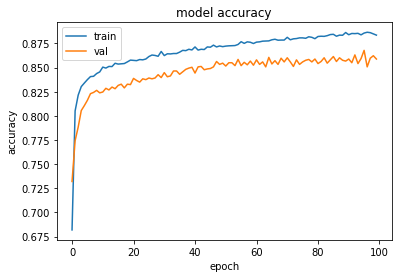

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

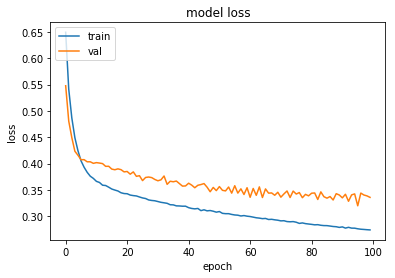

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

saved-model-100-0.86.hdf5
Val loss: 0.31966368845193144
Val accuracy: 0.87425405


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/iterator_ops.py:420: UserWarning: An unusually high number of `Iterator.get_next()` calls was detected. This often indicates that `Iterator.get_next()` is being called inside a training loop, which will cause gradual slowdown and eventual resource exhaustion. If this is the case, restructure your code to call `next_element = iterator.get_next()` once outside the loop, and use `next_element` as the input to some computation that is invoked inside the loop.
  warnings.warn(GET_NEXT_CALL_WARNING_MESSAGE)


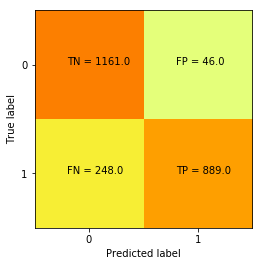

In [0]:
m = os.listdir(out_folder)[-1] # last model
print(m)
model.load_weights(os.path.join(out_folder, m))
score = model.evaluate(test_ds.make_one_shot_iterator(), verbose=0, steps=sum(test_ds_length))

print('Val loss:', score[0])
print('Val accuracy:', score[1])
plot_confusion_matrix(calc_confusion_matrix(tf.keras.backend.get_session(), 
                                          test_ds.make_one_shot_iterator(), 
                                          CONFUSION_MATRIX_VAL_DATASET_STEPS,
                                          model))


## Model 5

In [0]:
out_folder = '/content/drive/My Drive/ChestXRay/Model5CheckpointsC/'
filepath = os.path.join(out_folder, "saved-model-{epoch:02d}-{val_acc:.2f}.hdf5")
if not os.path.exists(out_folder):
  os.mkdir(out_folder)
  
  
# https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7
# Smaller filters detect small objects (kernel_size 3x3)
# Bigger filters detect greater objects (kernel_size 11x11)

# 1.Always start by using smaller filters is to collect as much local information as possible, 
# and then gradually increase the filter width to reduce the generated feature space width to 
# represent more global, high-level and representative information

# 2. Following the principle, the number of channels should be low in the beginning such that 
# it detects low-level features which are combined to form many complex shapes(by increasing the number of channels) 
# which help distinguish between classes.


# The border is not important in this problem, so no padding will be applied

# Increase filter length in smaller (and deeper) layers

# Considering the literature examples, VGG-16 and VGG-19 models, use 4 or 5 conv. layers

# Calculate the "image size" after each block

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
model = Sequential()

# 300x300x1
model.add(Conv2D(16, kernel_size=(3, 3), 
                 activation='relu',
                 input_shape=(*IMAGE_SIZE, 1)))
# 298x298x32
model.add(MaxPooling2D(pool_size=(2, 2)))
# 149x149x32

model.add(Conv2D(32, kernel_size=(3, 3), 
                 activation='relu'))
# 147x147x64
model.add(MaxPooling2D(pool_size=(2, 2)))
# 73x73x64

model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
# 71x71x128
model.add(MaxPooling2D(pool_size=(2, 2)))
# 35x35x128

model.add(Conv2D(128, kernel_size=(3, 3), 
                 activation='relu'))
# 33x33x256
model.add(MaxPooling2D(pool_size=(2, 2)))
# 16x16x256

model.add(Flatten()) # (65536) # Just to linearize the output
model.add(Dropout(0.50)) # the idea here is to turn off half of the values, so the network learns how to deal with different informations

# https://stackoverflow.com/questions/24509921/how-do-you-decide-the-parameters-of-a-convolutional-neural-network-for-image-cla
# The recomendation is to use only two hidden, three will (probably) cause overfitting

model.add(Dense(256, activation='sigmoid'))
model.add(Dense(256, activation='sigmoid'))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [0]:
history = model.fit(train_ds.make_one_shot_iterator(),
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          epochs=EPOCHS,
          verbose=1,
          validation_data=val_ds.make_one_shot_iterator(),
          callbacks = [checkpoint])

Epoch 1/50
879/880 [============================>.] - ETA: 0s - loss: 0.6948 - acc: 0.5482
Epoch 00001: saving model to /content/drive/My Drive/ChestXRay/Model5CheckpointsC/saved-model-01-0.69.hdf5
880/880 [==============================] - 39s 44ms/step - loss: 0.6947 - acc: 0.5484 - val_loss: 0.8641 - val_acc: 0.6875
Epoch 2/50
878/880 [============================>.] - ETA: 0s - loss: 0.6539 - acc: 0.6772
Epoch 00002: saving model to /content/drive/My Drive/ChestXRay/Model5CheckpointsC/saved-model-02-0.69.hdf5
880/880 [==============================] - 35s 40ms/step - loss: 0.6538 - acc: 0.6773 - val_loss: 0.8092 - val_acc: 0.6875
Epoch 3/50
878/880 [============================>.] - ETA: 0s - loss: 0.6235 - acc: 0.7481
Epoch 00003: saving model to /content/drive/My Drive/ChestXRay/Model5CheckpointsC/saved-model-03-0.69.hdf5
880/880 [==============================] - 35s 40ms/step - loss: 0.6236 - acc: 0.7477 - val_loss: 0.8059 - val_acc: 0.6875
Epoch 4/50
879/880 [=================

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

saved-model-50-0.84.hdf5
Val loss: 0.4865774206975673
Val accuracy: 0.79148936


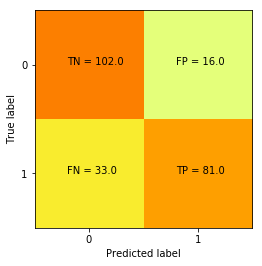

In [0]:
m = os.listdir(out_folder)[-1]
print(m)
model.load_weights(os.path.join(out_folder, m))
score = model.evaluate(test_ds.make_one_shot_iterator(), verbose=0, steps=sum(test_ds_length))

print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_confusion_matrix(calc_confusion_matrix(tf.keras.backend.get_session(), 
                                          test_ds.make_one_shot_iterator(), 
                                          CONFUSION_MATRIX_VAL_DATASET_STEPS,
                                          model))

## Model 6

In [0]:
out_folder = '/content/drive/My Drive/ChestXRay/Model6CheckpointsC/'
filepath = os.path.join(out_folder, "saved-model-{epoch:02d}-{val_acc:.2f}.hdf5")
if not os.path.exists(out_folder):
  os.mkdir(out_folder)
  
  
# https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7
# Smaller filters detect small objects (kernel_size 3x3)
# Bigger filters detect greater objects (kernel_size 11x11)

# 1.Always start by using smaller filters is to collect as much local information as possible, 
# and then gradually increase the filter width to reduce the generated feature space width to 
# represent more global, high-level and representative information

# 2. Following the principle, the number of channels should be low in the beginning such that 
# it detects low-level features which are combined to form many complex shapes(by increasing the number of channels) 
# which help distinguish between classes.


# The border is not important in this problem, so no padding will be applied

# Increase filter length in smaller (and deeper) layers

# Considering the literature examples, VGG-16 and VGG-19 models, use 4 or 5 conv. layers

# Calculate the "image size" after each block

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
model = Sequential()

# 300x300x1
model.add(Conv2D(32, kernel_size=(3, 3), 
                 activation='relu',
                 input_shape=(*IMAGE_SIZE, 1)))
# 298x298x32
model.add(MaxPooling2D(pool_size=(2, 2)))
# 149x149x32

model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
# 147x147x64
model.add(MaxPooling2D(pool_size=(2, 2)))
# 73x73x64

model.add(Conv2D(128, kernel_size=(3, 3), 
                 activation='relu'))
# 71x71x128
model.add(MaxPooling2D(pool_size=(2, 2)))
# 35x35x128

model.add(Conv2D(256, kernel_size=(3, 3), 
                 activation='relu'))
# 33x33x256
model.add(MaxPooling2D(pool_size=(2, 2)))
# 16x16x256

model.add(Flatten()) # (65536) # Just to linearize the output
model.add(Dropout(0.50)) # the idea here is to turn off half of the values, so the network learns how to deal with different informations

# https://stackoverflow.com/questions/24509921/how-do-you-decide-the-parameters-of-a-convolutional-neural-network-for-image-cla
# The recomendation is to use only two hidden, three will (probably) cause overfitting

model.add(Dense(512, activation='sigmoid'))
model.add(Dense(512, activation='sigmoid'))

model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [0]:
history = model.fit(train_ds.make_one_shot_iterator(),
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          epochs=EPOCHS,
          verbose=1,
          validation_data=val_ds.make_one_shot_iterator(),
          callbacks = [checkpoint])

Epoch 1/100
879/880 [============================>.] - ETA: 0s - loss: 0.7852 - acc: 0.6027
Epoch 00001: saving model to /content/drive/My Drive/ChestXRay/Model6CheckpointsC/saved-model-01-0.57.hdf5
880/880 [==============================] - 430s 488ms/step - loss: 0.7850 - acc: 0.6030 - val_loss: 0.6406 - val_acc: 0.5708
Epoch 2/100
879/880 [============================>.] - ETA: 0s - loss: 0.5709 - acc: 0.7568
Epoch 00002: saving model to /content/drive/My Drive/ChestXRay/Model6CheckpointsC/saved-model-02-0.78.hdf5
880/880 [==============================] - 70s 80ms/step - loss: 0.5709 - acc: 0.7570 - val_loss: 0.5030 - val_acc: 0.7820
Epoch 3/100
879/880 [============================>.] - ETA: 0s - loss: 0.4976 - acc: 0.7894
Epoch 00003: saving model to /content/drive/My Drive/ChestXRay/Model6CheckpointsC/saved-model-03-0.79.hdf5
880/880 [==============================] - 71s 81ms/step - loss: 0.4976 - acc: 0.7895 - val_loss: 0.4677 - val_acc: 0.7905
Epoch 4/100
879/880 [===========

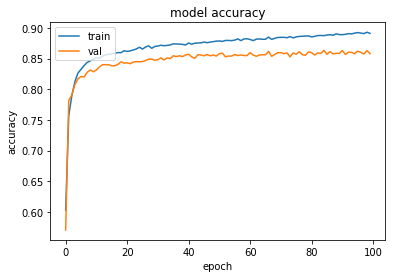

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

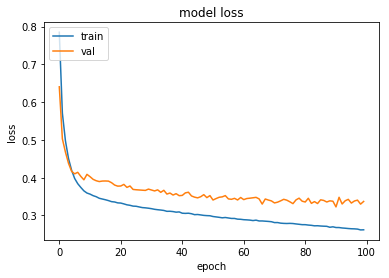

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

saved-model-100-0.86.hdf5
Val loss: 0.3177511746386179
Val accuracy: 0.87638533


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/iterator_ops.py:420: UserWarning: An unusually high number of `Iterator.get_next()` calls was detected. This often indicates that `Iterator.get_next()` is being called inside a training loop, which will cause gradual slowdown and eventual resource exhaustion. If this is the case, restructure your code to call `next_element = iterator.get_next()` once outside the loop, and use `next_element` as the input to some computation that is invoked inside the loop.
  warnings.warn(GET_NEXT_CALL_WARNING_MESSAGE)


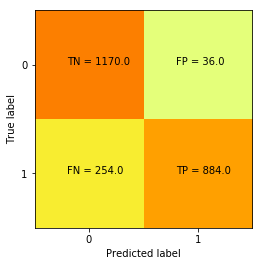

In [0]:
m = os.listdir(out_folder)[-1]
print(m)
model.load_weights(os.path.join(out_folder, m))
score = model.evaluate(test_ds.make_one_shot_iterator(), verbose=0, steps=sum(test_ds_length))

print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_confusion_matrix(calc_confusion_matrix(tf.keras.backend.get_session(), 
                                          test_ds.make_one_shot_iterator(), 
                                          CONFUSION_MATRIX_VAL_DATASET_STEPS,
                                          model))